# Betting markets - chart individual seat probabilities

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Plot-distribution-of-simple-overrounds" data-toc-modified-id="Plot-distribution-of-simple-overrounds-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot distribution of simple overrounds</a></span></li><li><span><a href="#Plot-seats" data-toc-modified-id="Plot-seats-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot seats</a></span><ul class="toc-item"><li><span><a href="#Plot" data-toc-modified-id="Plot-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plot</a></span></li><li><span><a href="#Seats-that-look-like-a-close-contest" data-toc-modified-id="Seats-that-look-like-a-close-contest-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Seats that look like a close contest</a></span></li><li><span><a href="#Seats-where-Greens-most-competitve" data-toc-modified-id="Seats-where-Greens-most-competitve-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Seats where Greens most competitve</a></span></li><li><span><a href="#Seats-where-others-are-most-competitive" data-toc-modified-id="Seats-where-others-are-most-competitive-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Seats where others are most competitive</a></span></li></ul></li></ul></div>

## Python set-up

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import common

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
munits.registry[pd.Timestamp] = converter
munits.registry[pd.Period] = converter
plt.style.use('./markgraph.mplstyle')

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Feb 24 2022 19:24:37

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

seaborn   : 0.11.2
numpy     : 1.22.2
pandas    : 1.4.1
matplotlib: 3.5.1

Watermark: 2.3.0



## Get data

In [3]:
FILE = '../historical-data/sportsbet-2022-individual-seats.csv'
df = pd.read_csv(FILE, na_values = 'SUS', parse_dates=['datetime'])
df = df[df['value'].notna()] # ignore missing values
len(df)

25814

In [4]:
df.columns

Index(['datetime', 'seat', 'variable', 'value'], dtype='object')

## Plot distribution of simple overrounds

In [5]:
overrounds = {}
for seat in df.seat.unique():
    overrounds[seat] = (
        df[df.seat == seat]
        .pivot(index='datetime', columns='variable', values='value')
        .iloc[-1]
        .pipe(lambda x: 1 / x)
        .sum()
    )
overround_series = pd.Series(overrounds)
overround_series

Banks (NSW)        1.152581
Barton (NSW)       1.133635
Bennelong (NSW)    1.139582
Berowra (NSW)      1.131437
Blaxland (NSW)     1.133635
                     ...   
Bean (ACT)         1.178496
Canberra (ACT)     1.178496
Lingiari (NT)      1.145667
Solomon (NT)       1.147346
Tangney (WA)       1.149682
Length: 151, dtype: float64

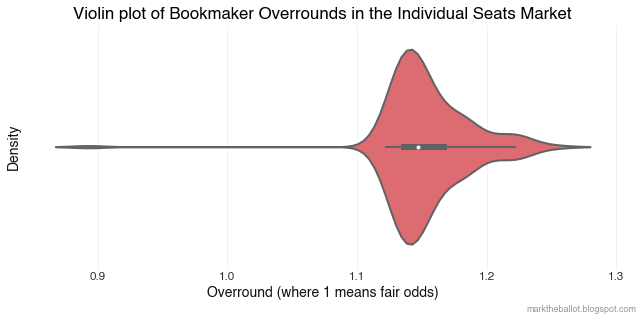

In [6]:
overround_series.index = range(len(overround_series))
ax = sns.violinplot(x=overround_series,
               orient='h')
title = 'Violin plot of Bookmaker Overrounds in the Individual Seats Market'
common.plot_finalise(ax, title=title, 
                     ylabel='Density', 
                     xlabel='Overround (where 1 means fair odds)')

## Plot seats

In [7]:
def colourise(s:str) -> str:
    colors = {
        'coalition': 'navy',
        'labor':     '#cc0000',
        'green':     'darkgreen',
        'independent': 'darkorange',
        'one nation': 'darkorchid',
        'jacqui lambie network': 'dodgerblue'
    }
    for party in colors.keys():
        if party in s.lower():
            return colors[party]
    return 'hotpink'

def plot_seat(df:pd.DataFrame, seat:str) -> float:

    # get seat probabilities
    IGNORE_ODDS_ABOVE = 25 # dollars - minimise impact of the longshot bias
    seat_probs = (
        df[df.seat == seat]
        .pivot(index='datetime', columns='variable', values='value')
        .sort_index(ascending=True)
        
        # Favourite-Longshot Bias management
        # NOTE: change method statement at the end of this statement
        #.pipe(lambda x: x.where(x <= IGNORE_ODDS_ABOVE, other=np.nan)) 
        #.pipe(lambda x: x * x) 
        .pipe(lambda x: x * np.sqrt(x)) 

        .dropna(how='all', axis=1)
        .pipe(lambda x: 1 / x)
        .pipe(lambda x: x.div(other=x.sum(axis=1), axis=0))
    ) * 100 # per cent
    #flb_method = f'Favourite-Longshot Bias treatment: odds > ${IGNORE_ODDS_ABOVE} removed'
    #flb_method = 'Favourite-Longshot Bias treatment: odds-squared'
    #flb_method = 'Favourite-Longshot Bias treatment: none'
    flb_method = 'Favourite-Longshot Bias treatment: raw-odds * sqrt(raw-odds)'
    
    # capture some additional statistics
    latest = seat_probs.iloc[-1]
    latest_best = latest.max()
    leader = latest.idxmax()
    green_prob = None if 'Green' not in latest.index else latest['Green']
    majors = ['Coalition', 'Liberal', 'Labor', 'Green']
    other_prob = latest[[x for x in latest.index if x not in majors]].sum()

    # plot
    markers = ['p', '+', 'D', 'o', 's', 'v', '^', ]
    fig, ax = plt.subplots()
    for i, column in enumerate(seat_probs.columns):
        c = colourise(column)
        m = markers[i]
        ax.plot(seat_probs.index, seat_probs[column], 
                markersize=6,
                lw=2, color=c, marker=m, label=column)
    ax.axhline(50, color='#999999', lw=0.5)
    ax.legend(loc='center left', prop={'size': 9}, ncol=2)
    title = f'Sportsbet seat win probabilities over time - {seat}'
    common.plot_finalise(ax, title=title, ylabel='Implied Win Probability (%)',
                         lfooter=flb_method, save_suffix=flb_method)
    
    # return additional statistics
    return latest_best, green_prob, other_prob, leader

### Plot

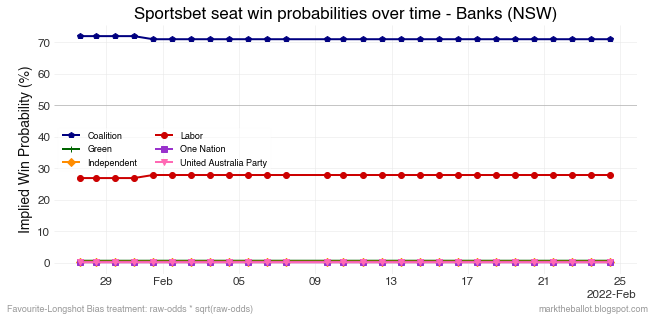

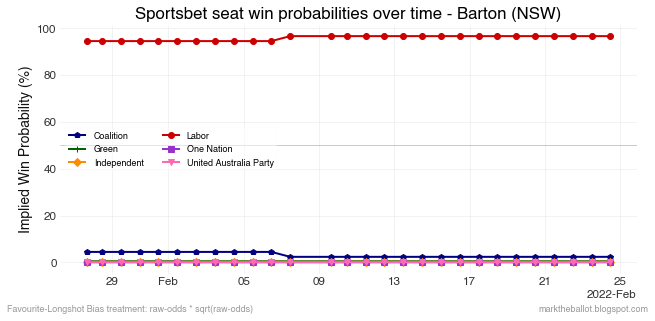

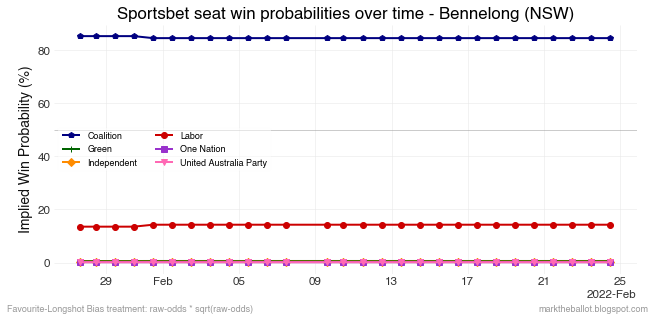

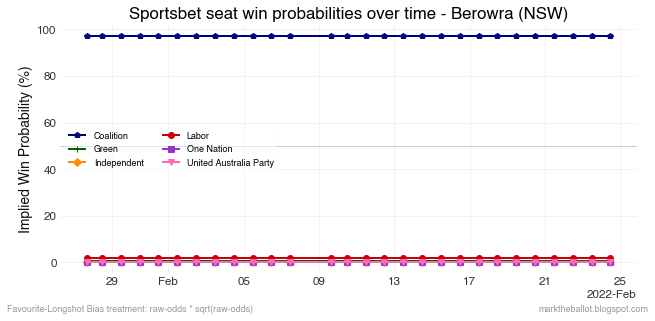

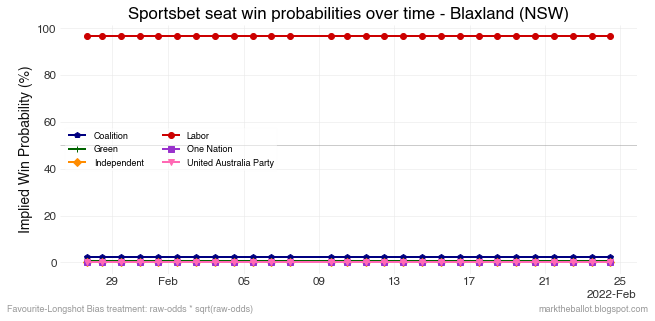

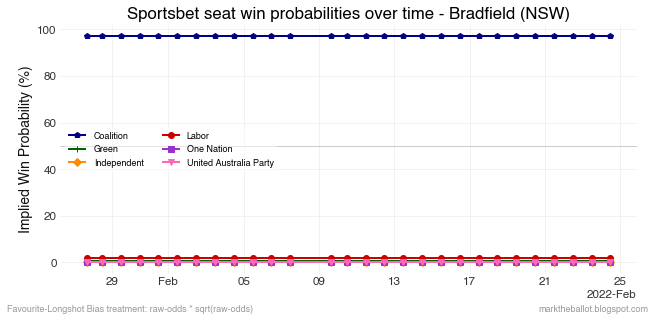

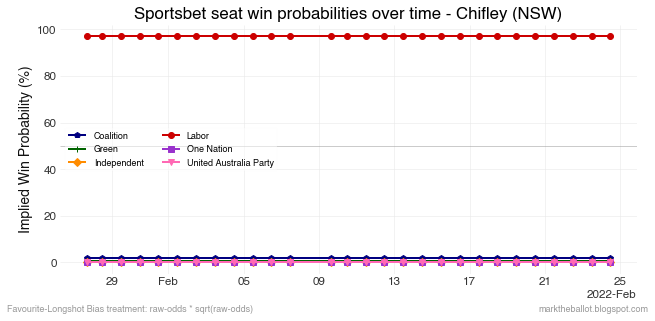

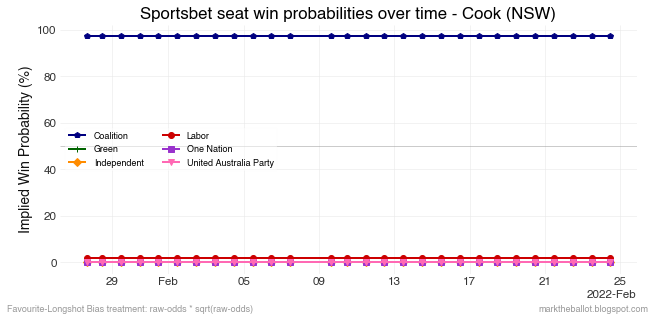

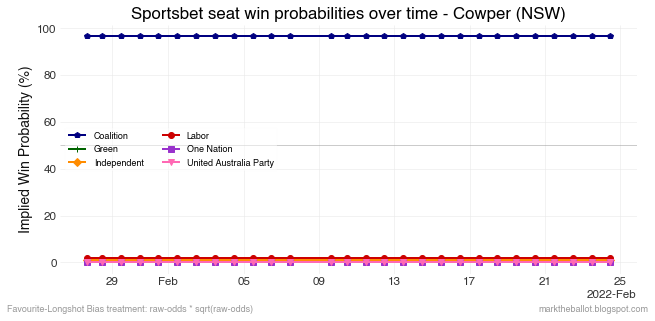

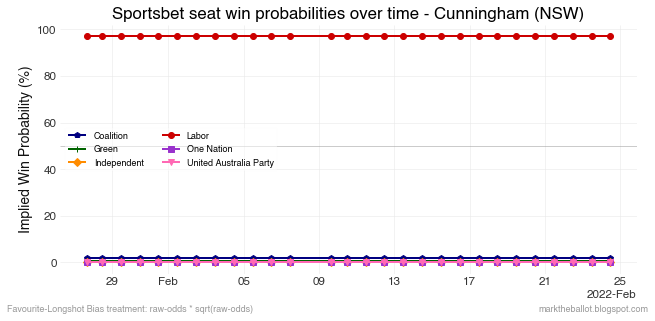

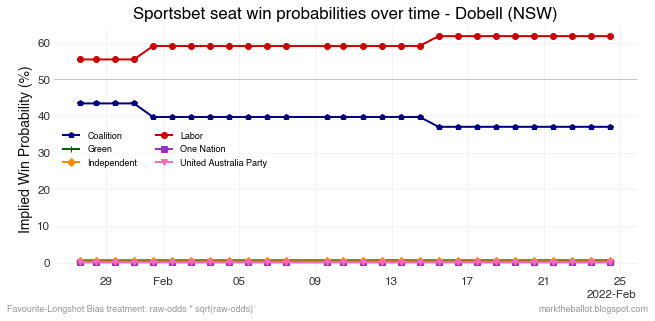

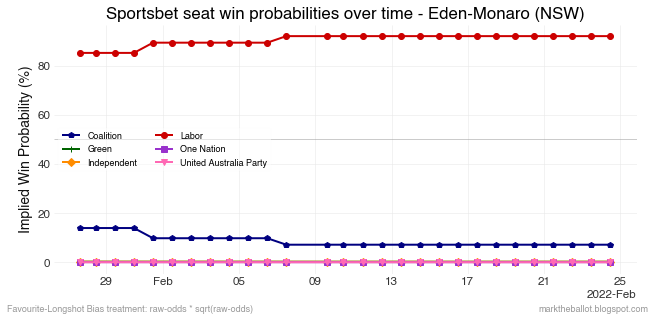

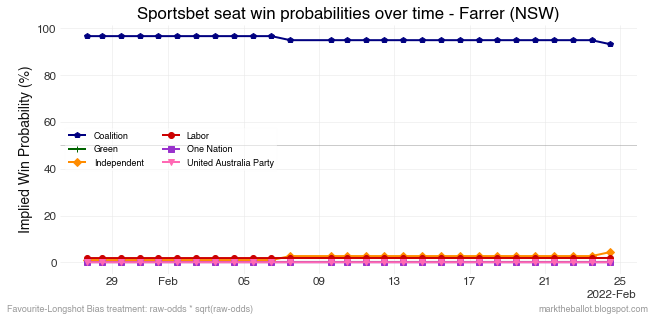

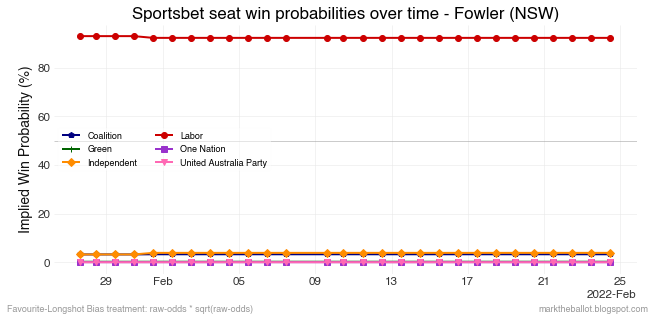

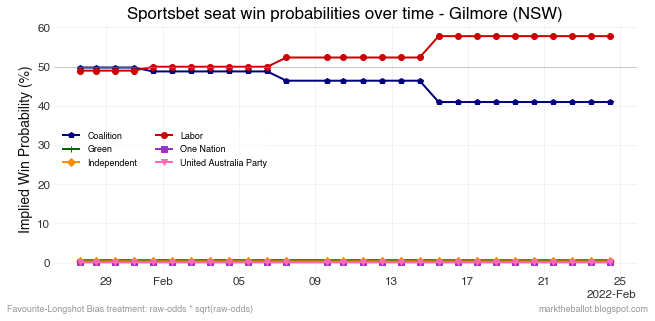

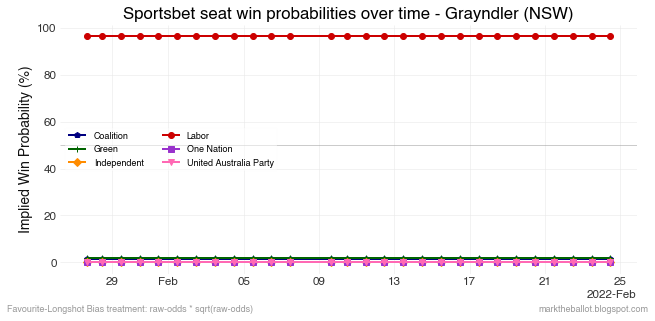

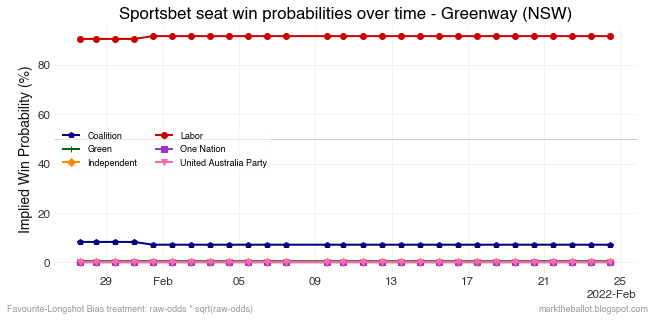

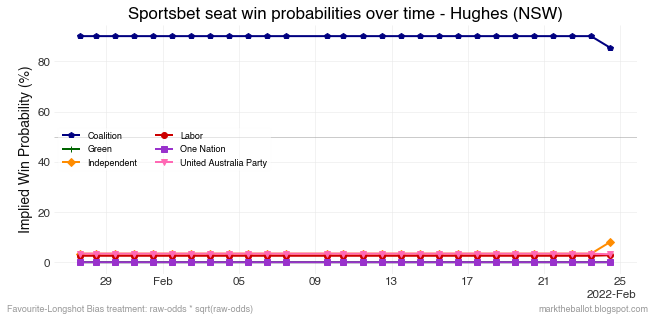

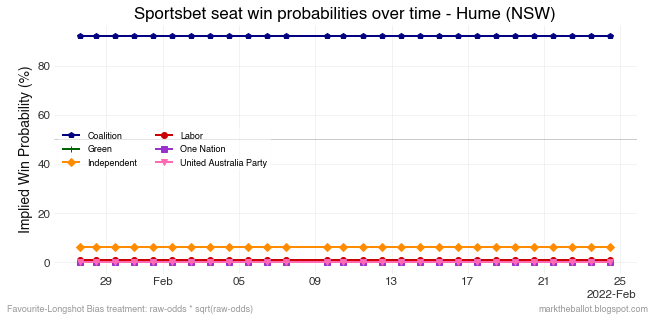

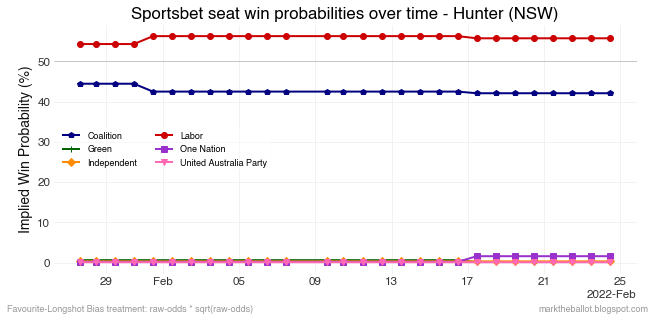

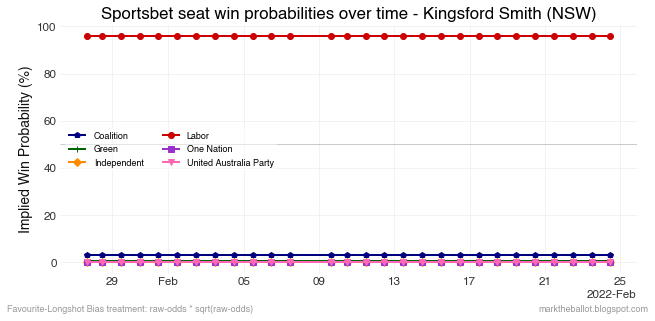

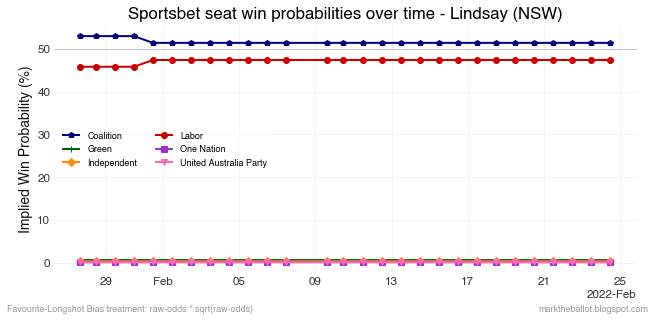

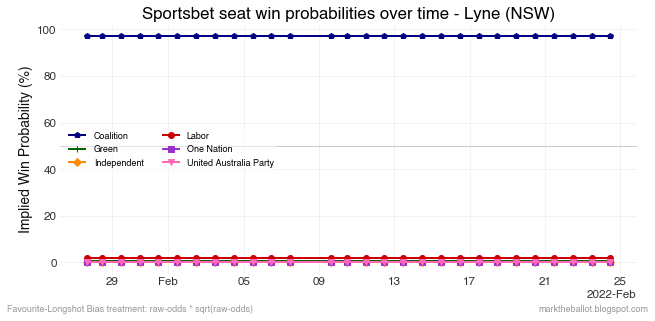

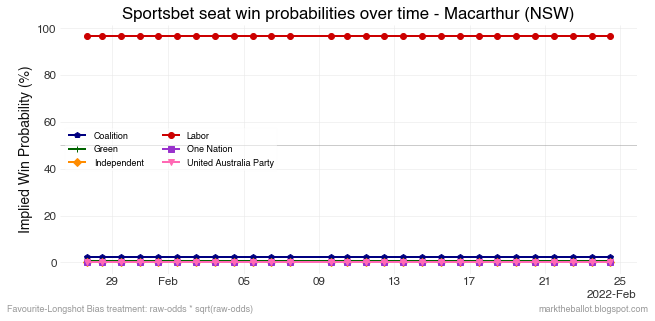

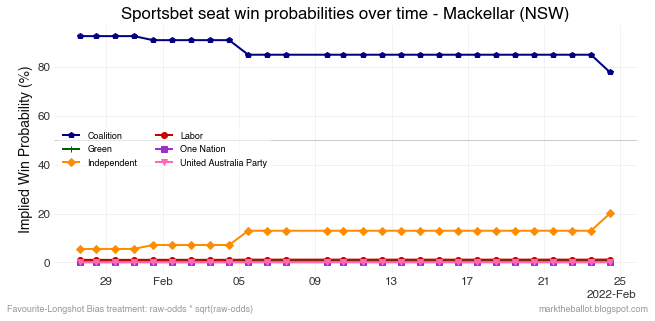

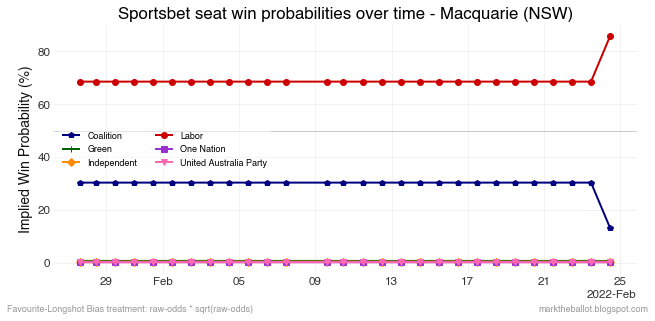

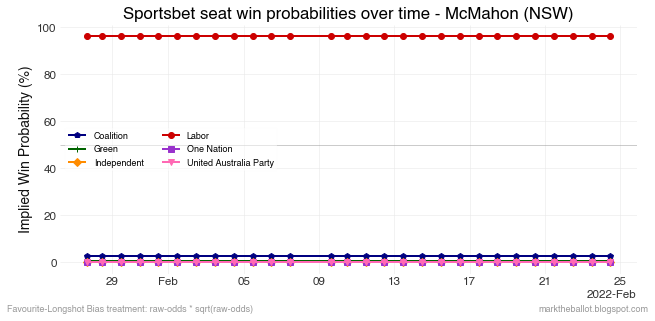

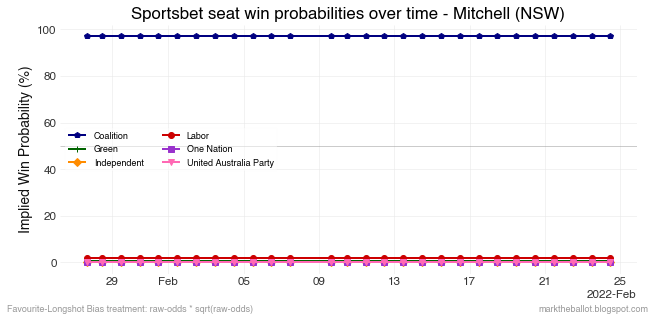

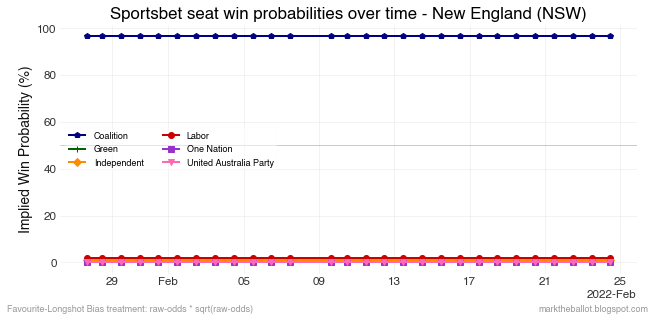

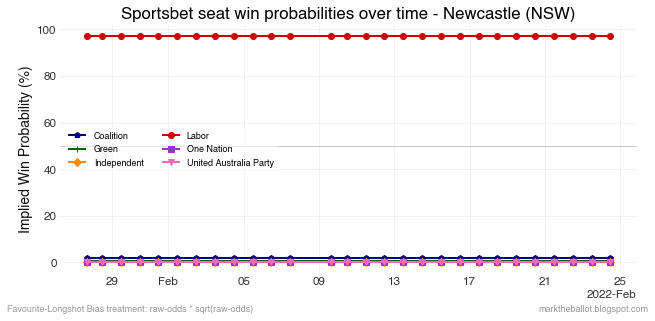

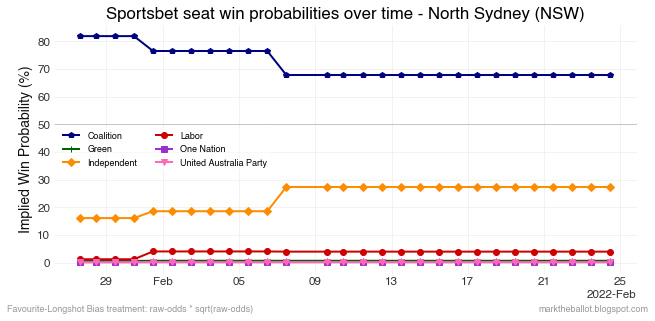

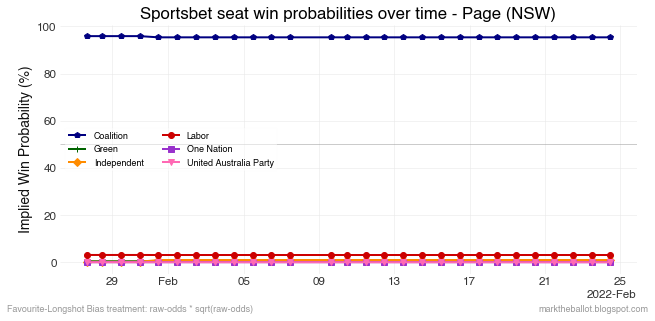

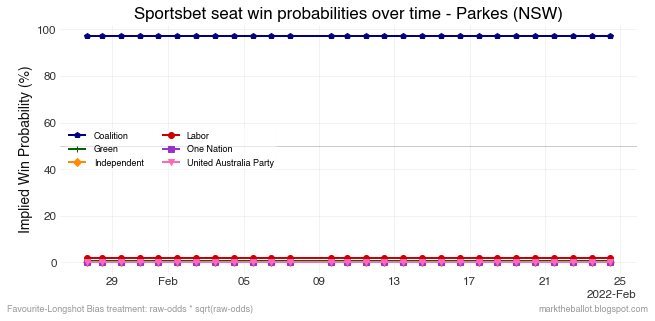

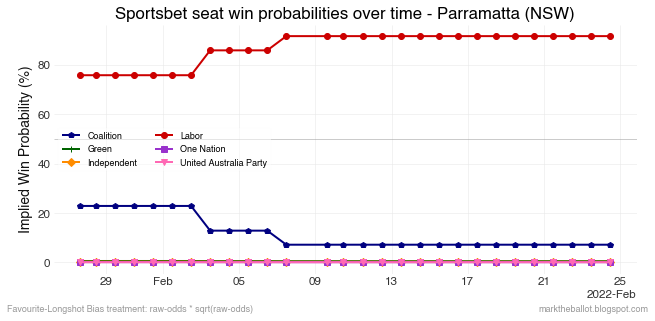

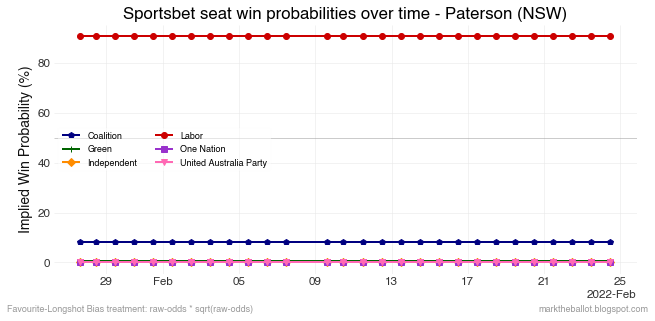

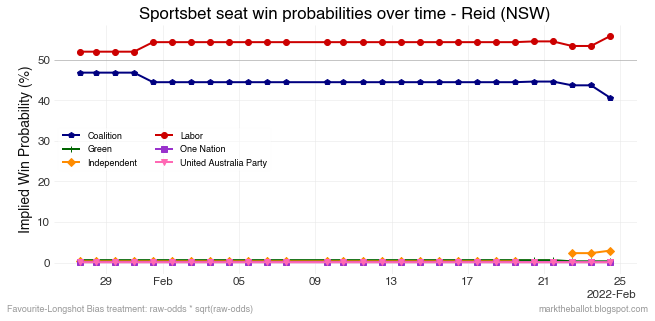

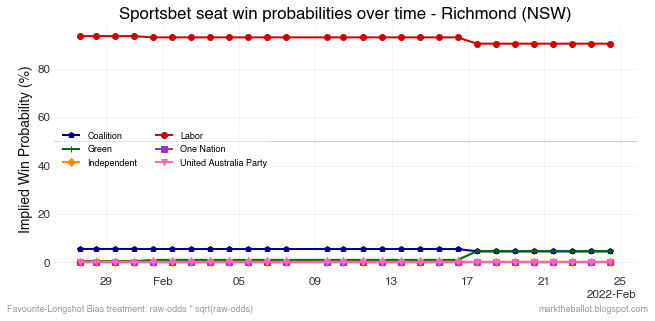

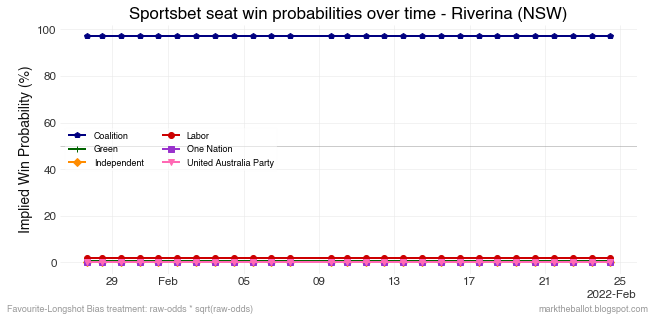

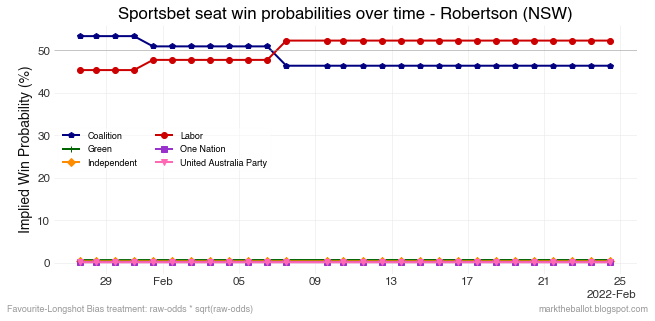

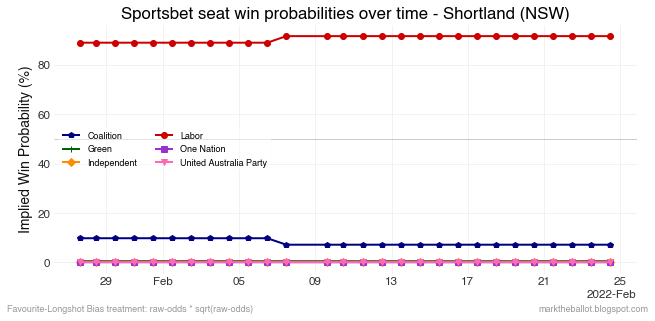

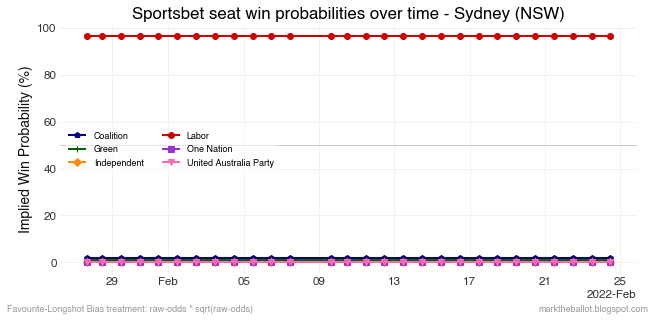

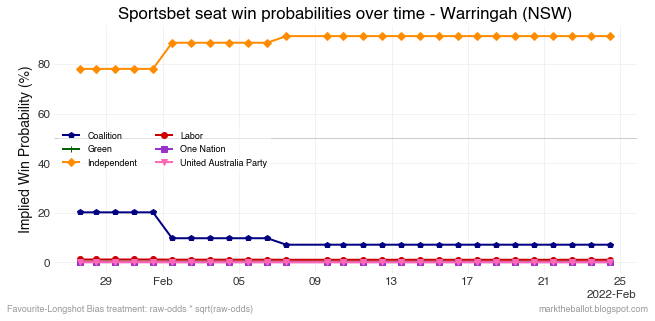

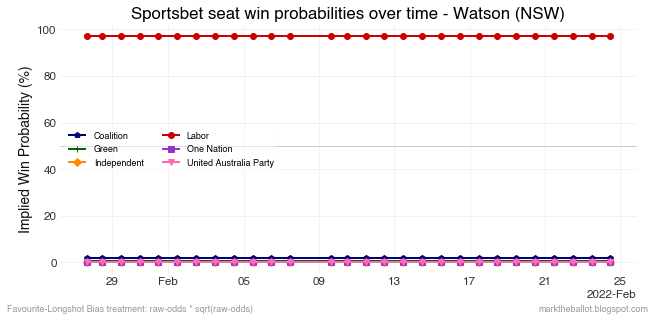

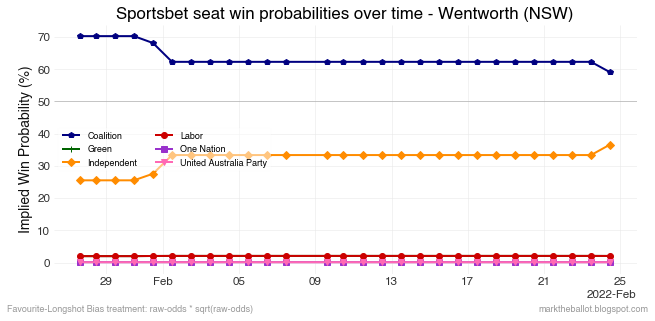

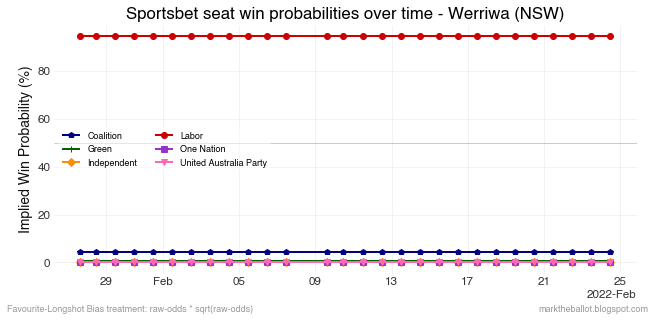

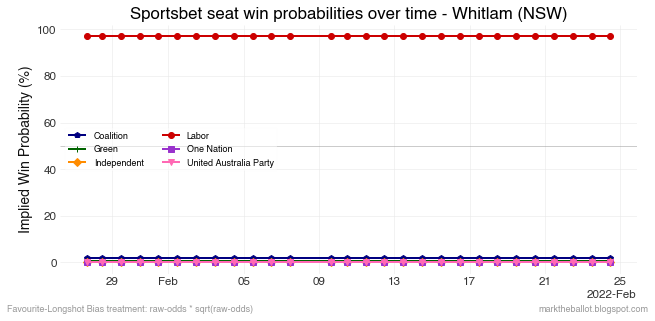

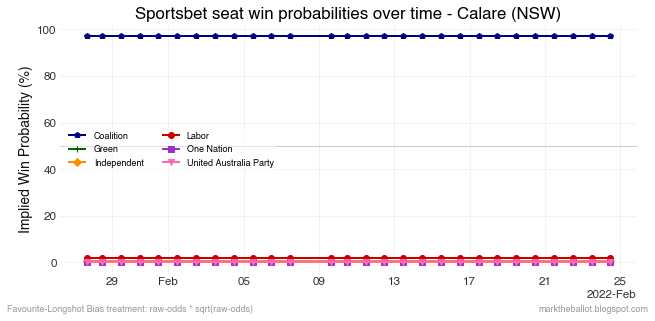

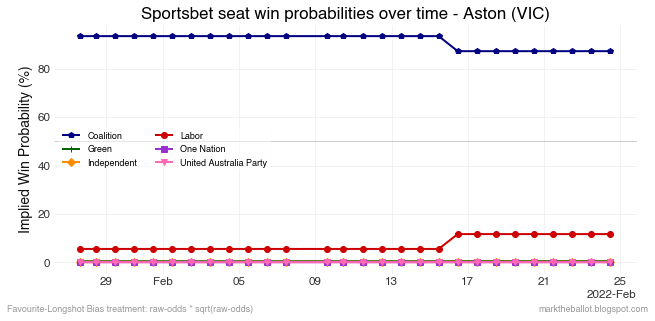

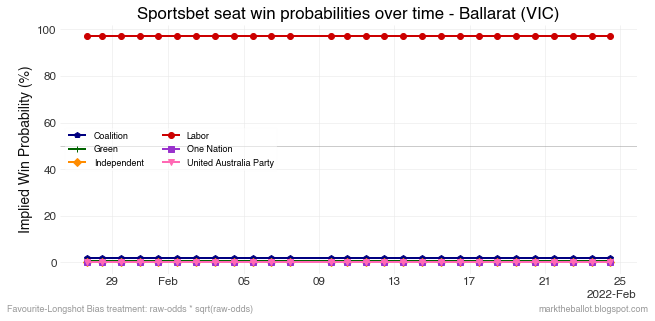

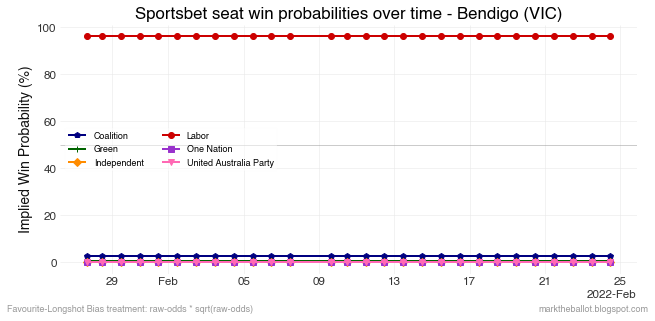

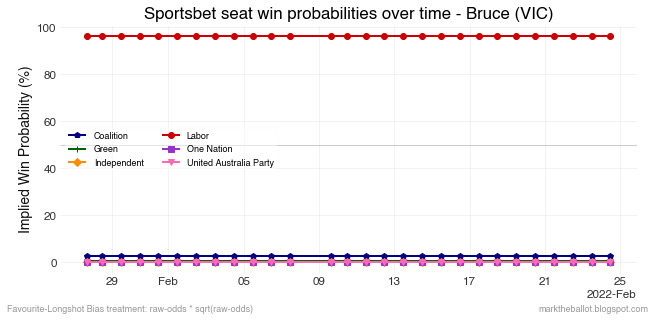

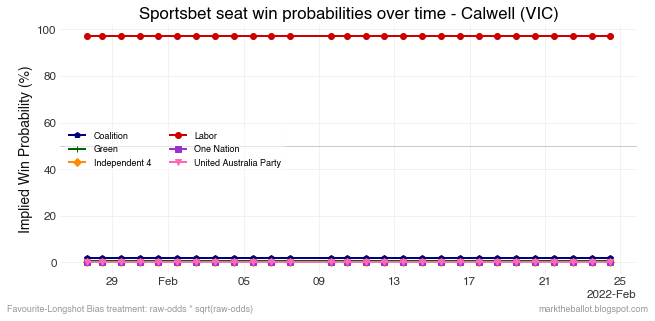

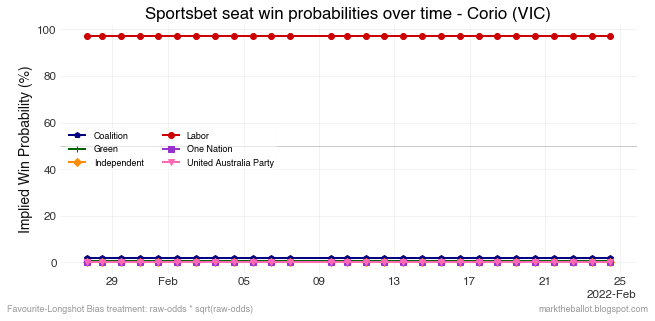

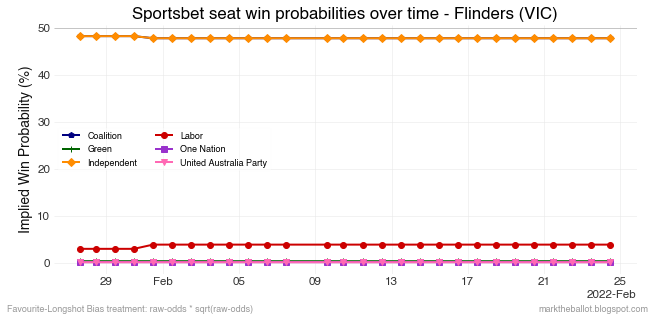

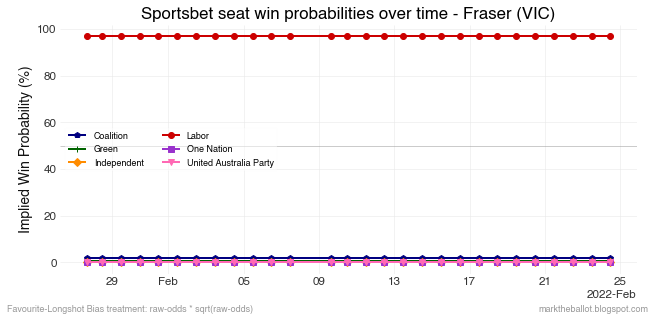

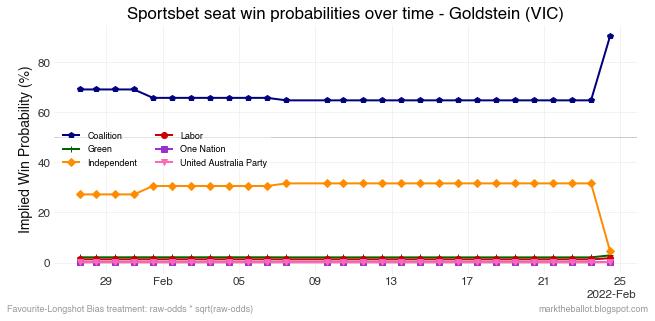

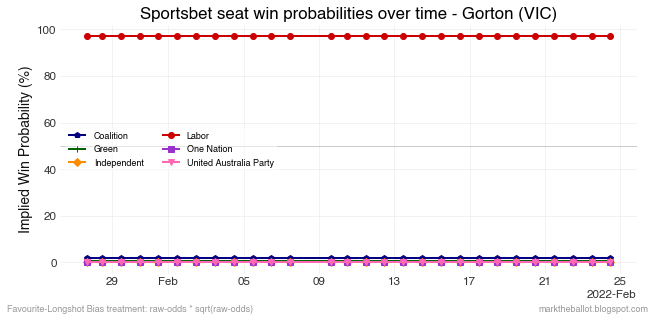

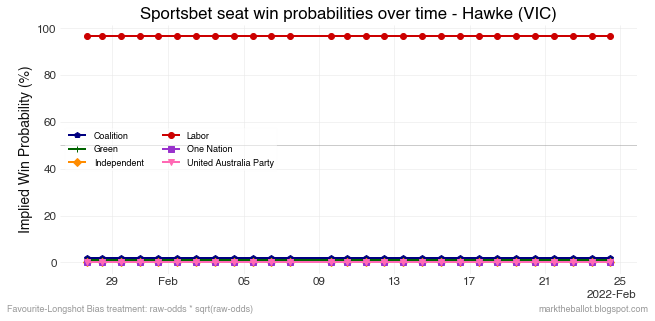

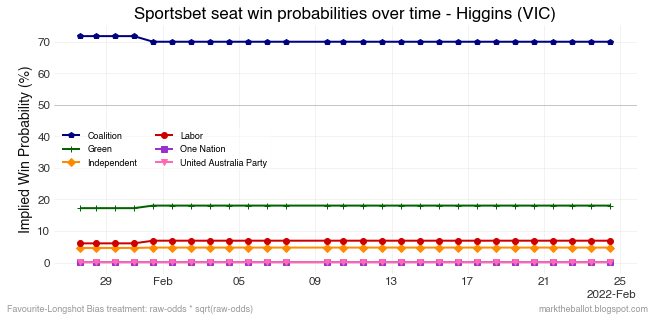

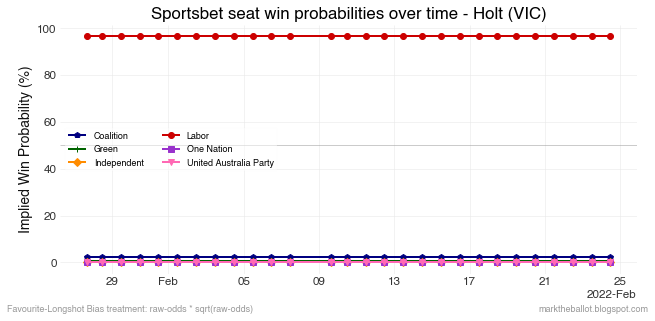

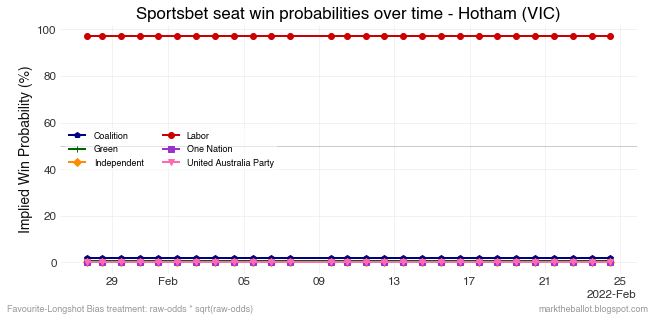

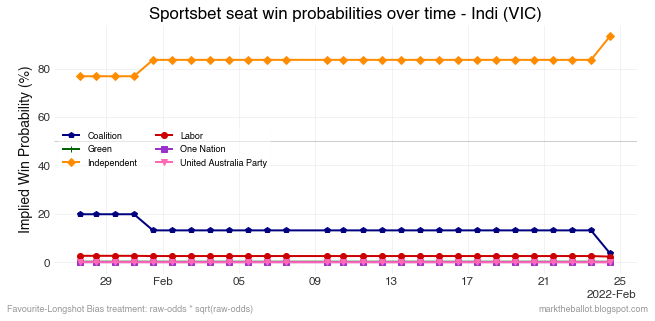

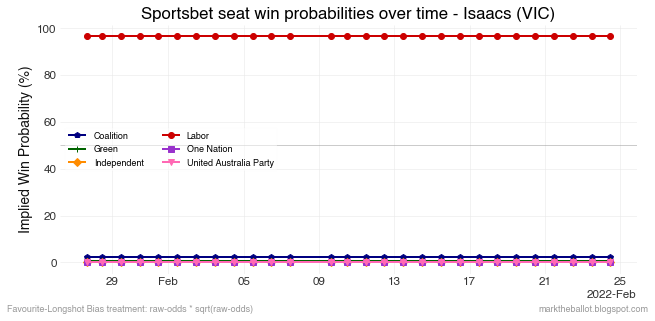

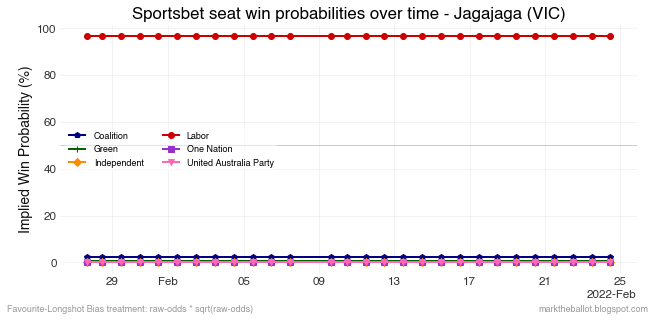

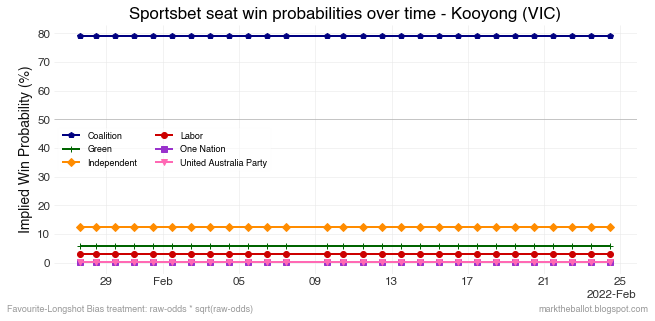

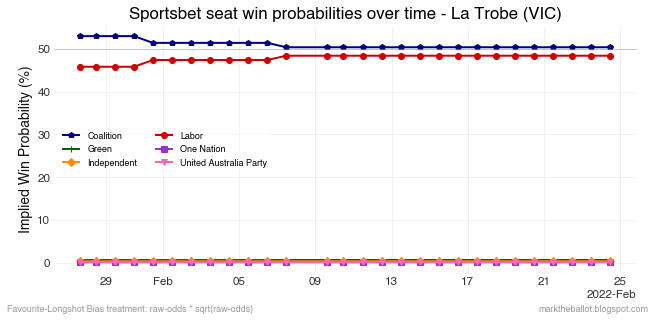

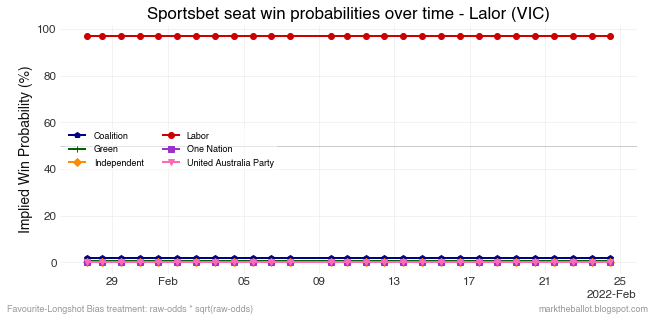

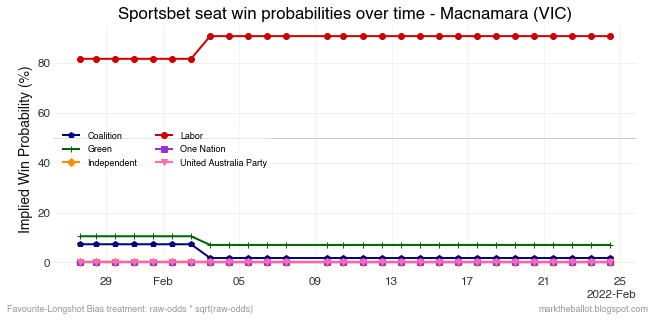

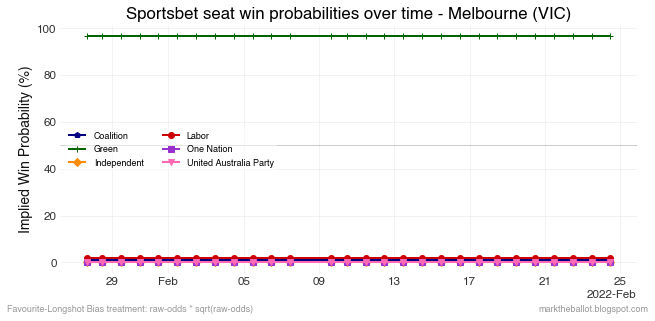

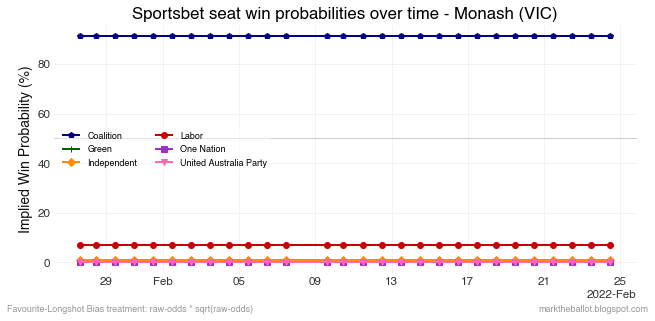

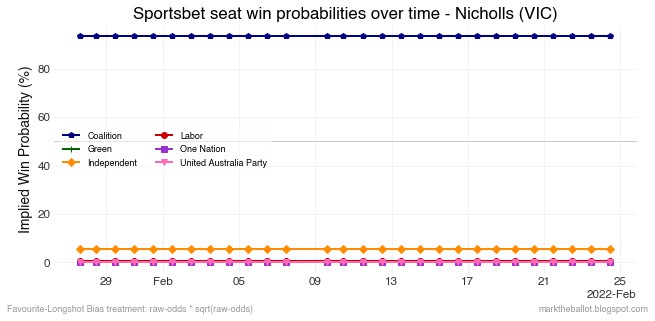

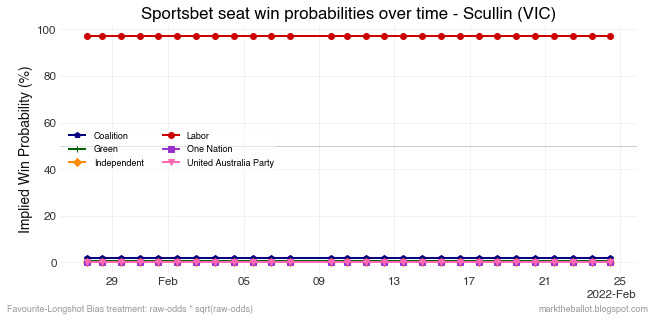

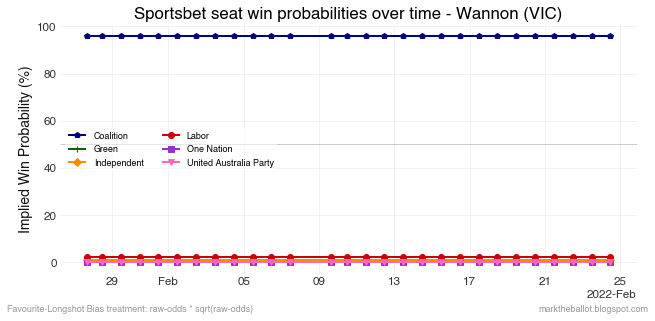

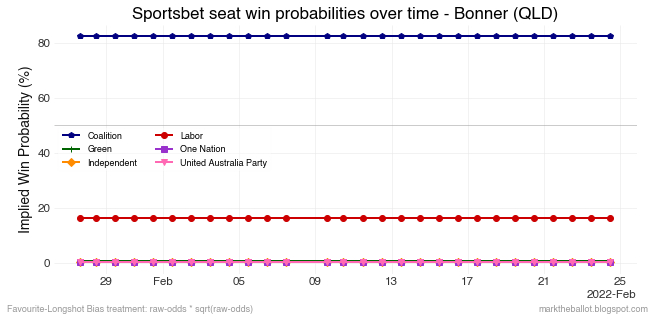

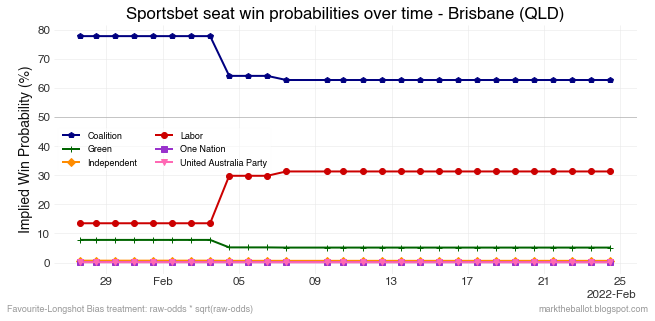

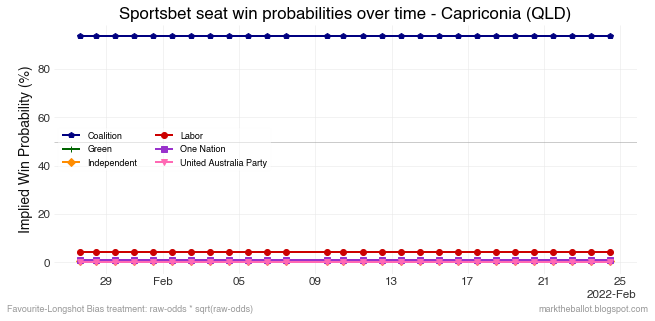

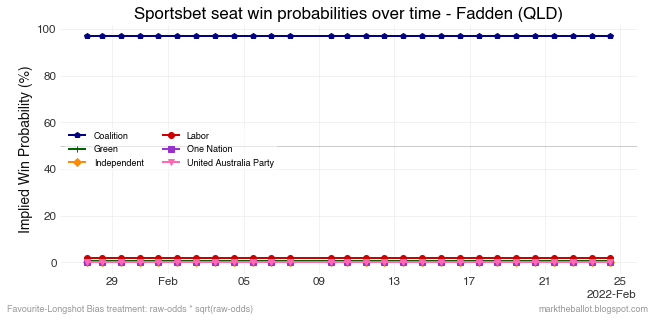

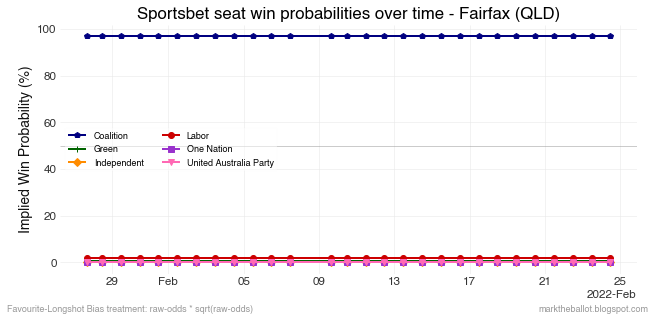

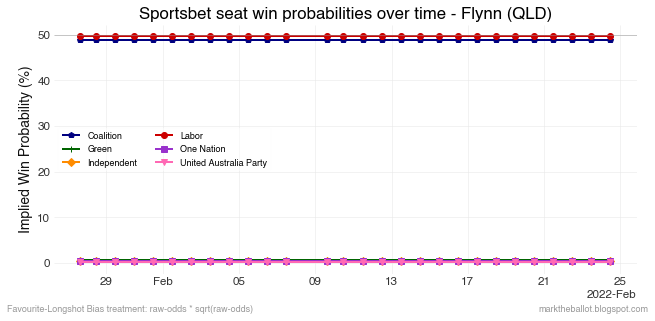

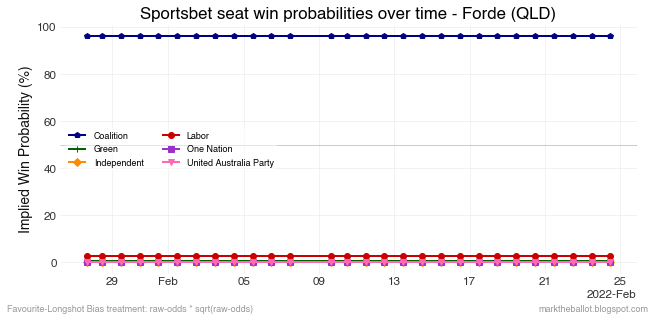

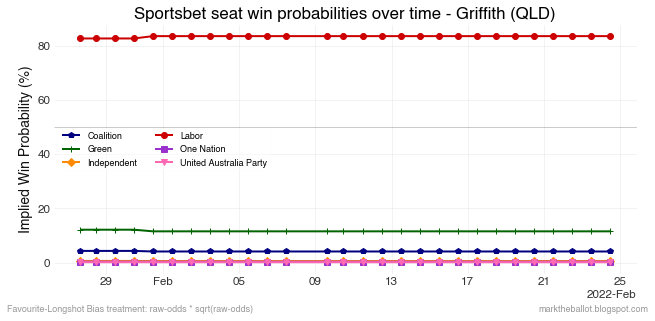

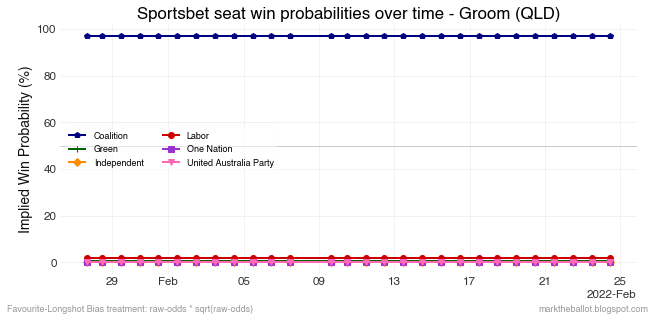

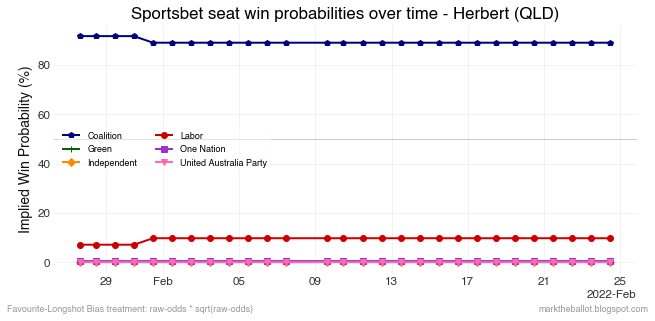

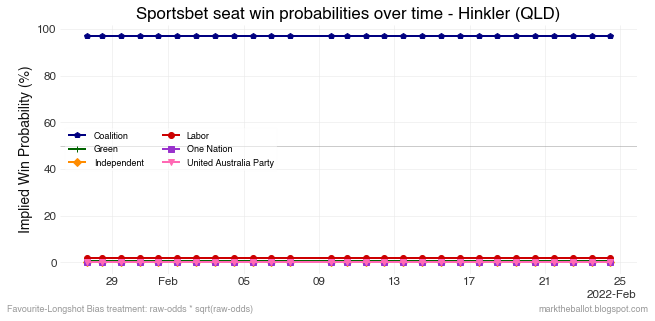

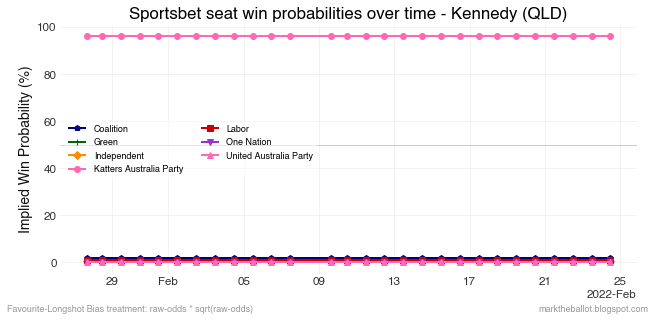

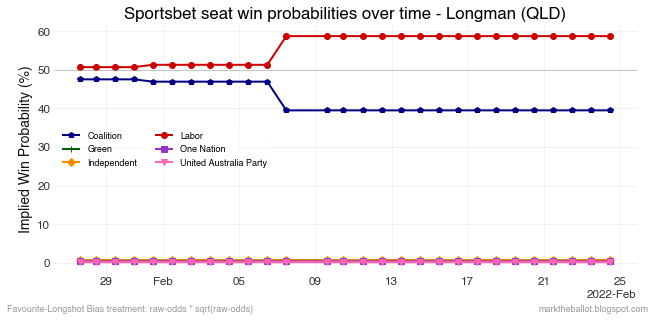

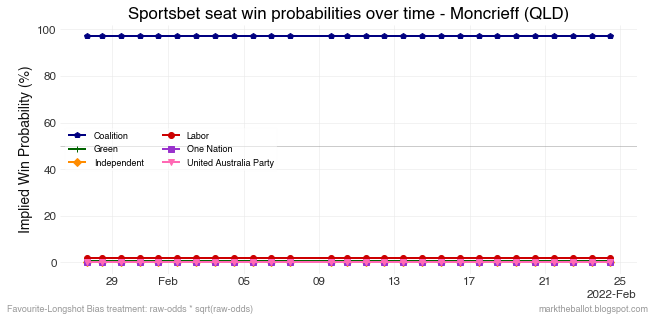

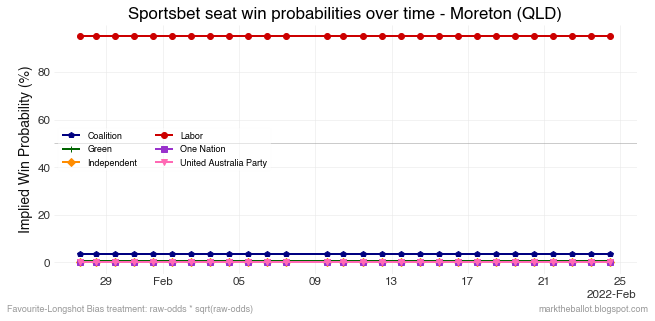

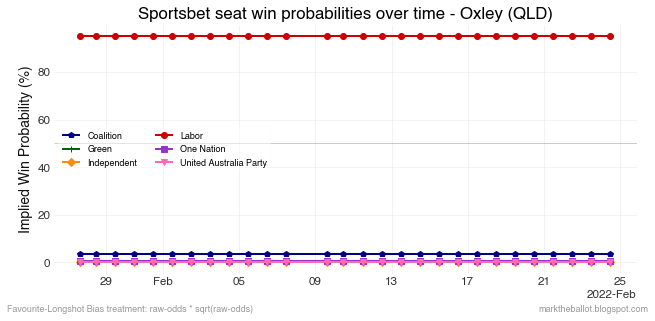

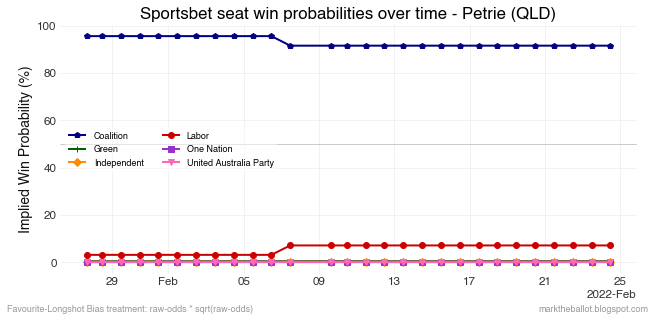

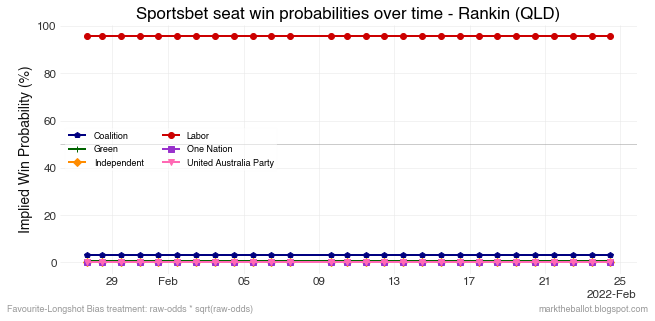

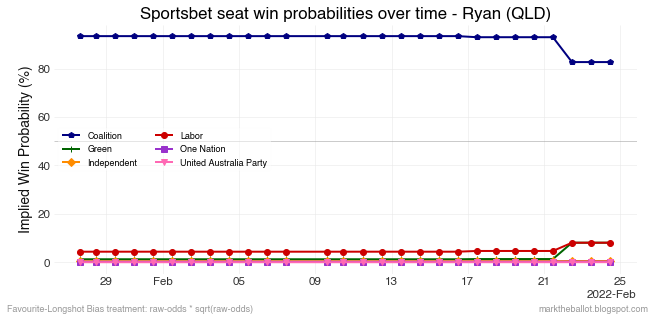

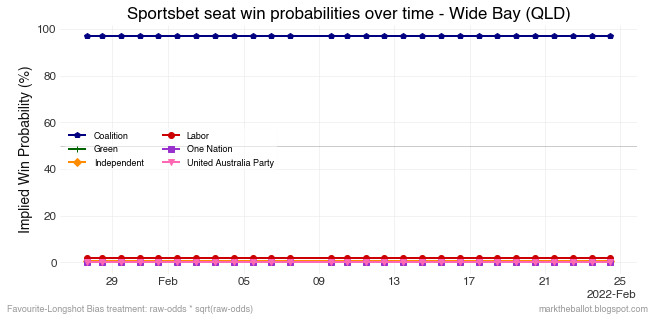

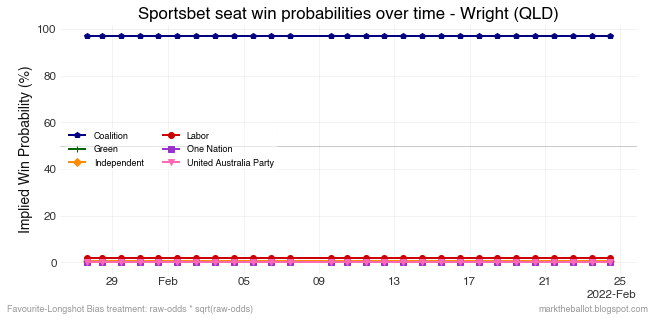

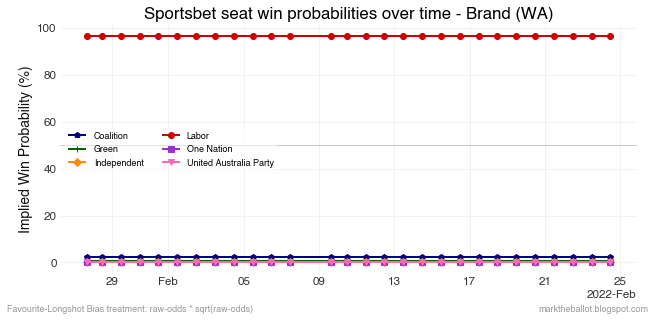

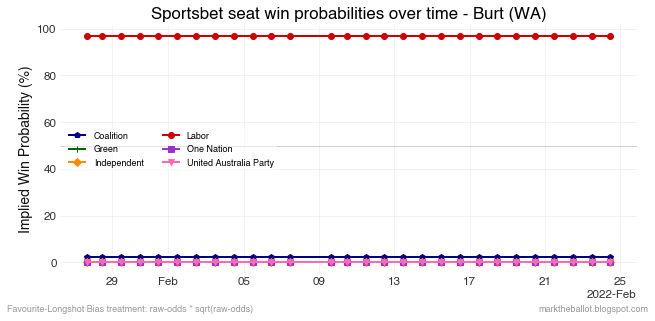

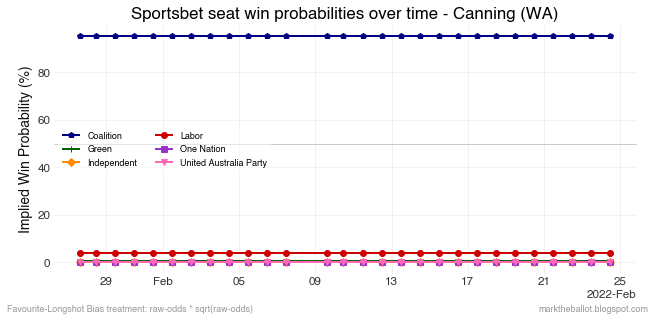

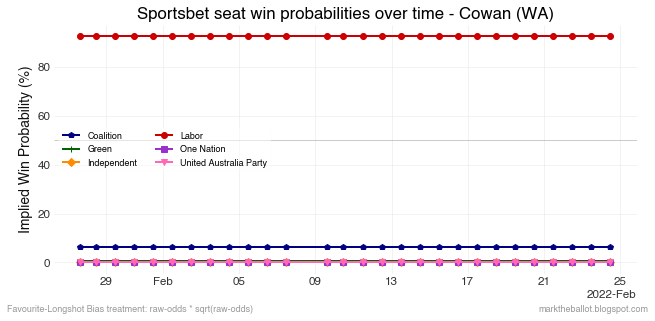

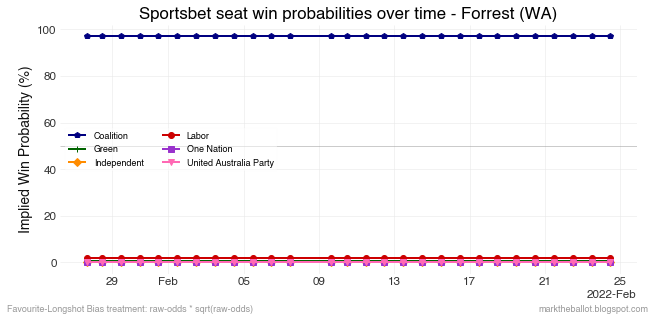

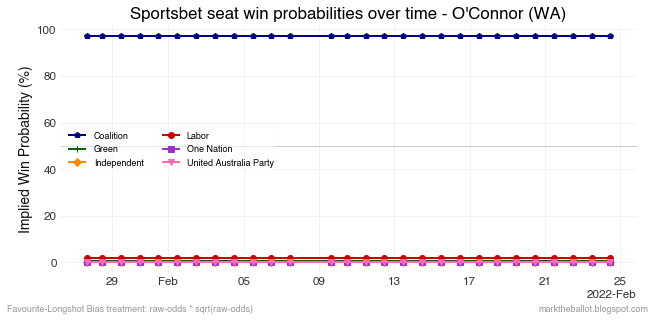

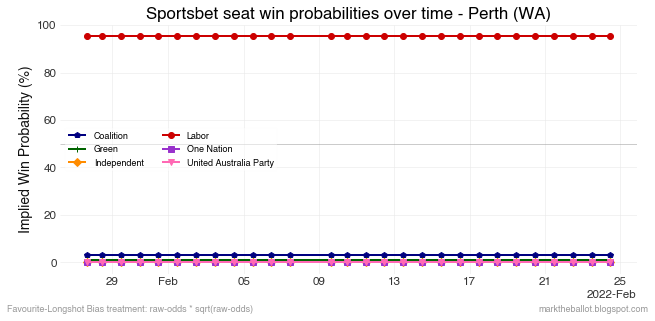

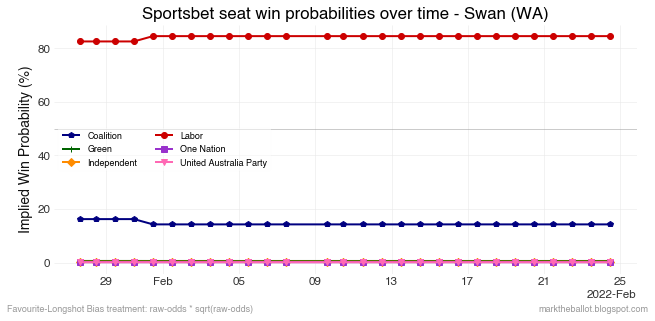

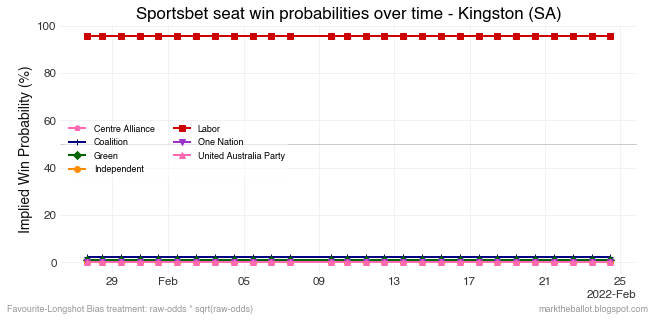

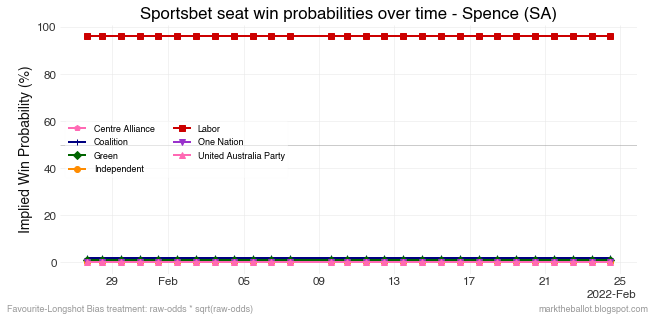

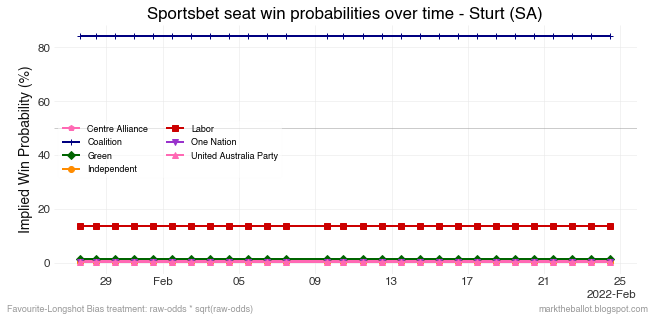

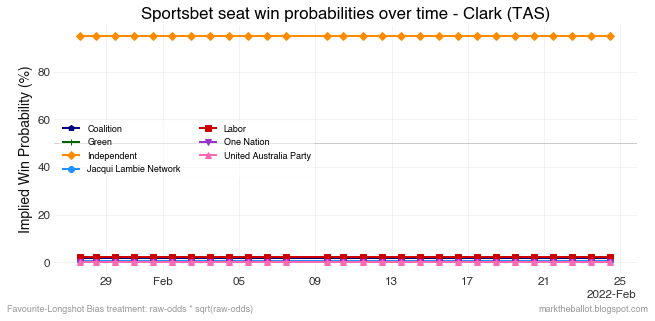

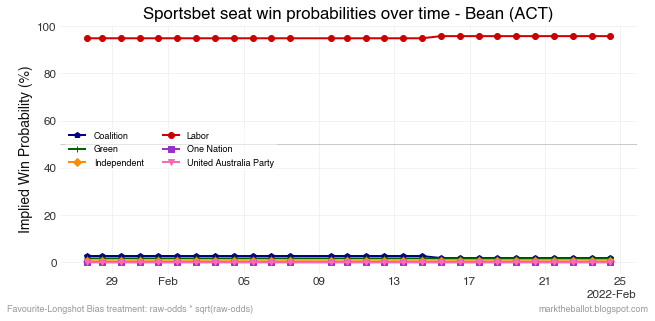

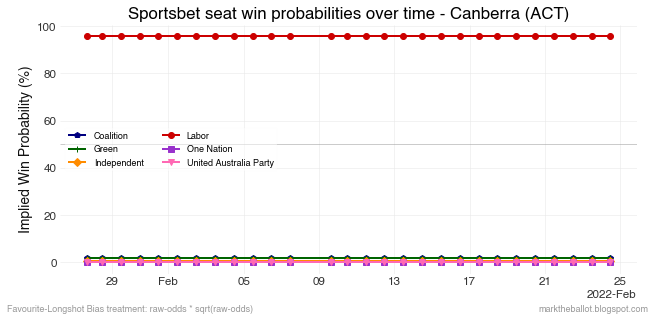

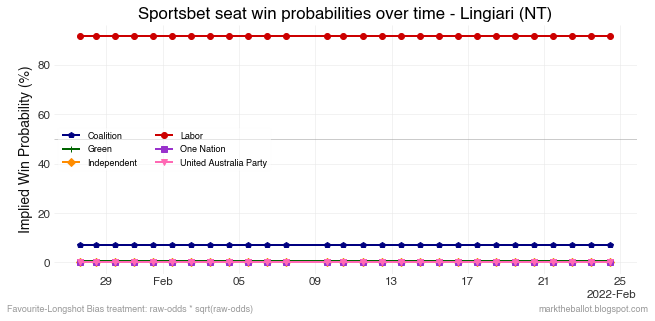

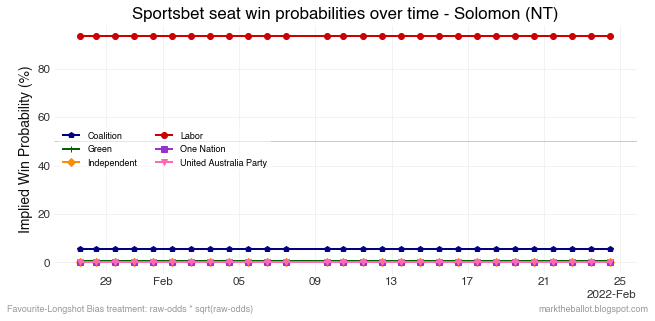

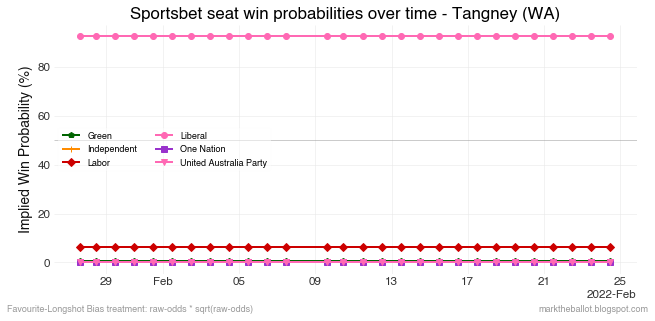

In [8]:
# produce plots
best_dict = {}
green_dict = {}
other_dict = {}
leader_dict = {}
for seat in df.seat.unique():
    best_dict[seat], green_dict[seat], other_dict[seat], leader_dict[seat] = plot_seat(df, seat)

### Seats that look like a close contest

In [9]:
# identiy the close contest seats
best_df = (
    pd.DataFrame([best_dict, leader_dict], index=['probability%', 'party ahead'])
    .T
    .sort_values('probability%', ascending=True)
)
best_df[best_df['probability%'] <= 75]

probability% party ahead
Flinders (VIC)        47.770285   Coalition
Braddon (TAS)         48.108806   Coalition
Flynn (QLD)           49.677369       Labor
Deakin (VIC)          49.776531   Coalition
La Trobe (VIC)        50.358404   Coalition
Casey (VIC)           50.902564   Coalition
Lindsay (NSW)         51.385517   Coalition
Robertson (NSW)         52.3331       Labor
Boothby (SA)          52.710378       Labor
Hunter (NSW)          55.694768       Labor
Reid (NSW)            55.787959       Labor
Bass (TAS)            56.940014       Labor
Gilmore (NSW)         57.783901       Labor
Longman (QLD)          58.76833       Labor
Wentworth (NSW)       59.024214   Coalition
Hasluck (WA)          59.054622   Coalition
Leichhardt (QLD)      61.615148   Coalition
Dobell (NSW)          61.737842       Labor
Brisbane (QLD)        62.720179   Coalition
North Sydney (NSW)    67.836513   Coalition
Higgins (VIC)         69.964803   Coalition
Banks (NSW)           70.955683   Coalition
Dickson (QLD)         72.341978   Coalition

### Seats where Greens most competitve

In [10]:
green_df = (
    pd.DataFrame([green_dict, leader_dict], index=['green probability %', 'party ahead'])
    .T
    .sort_values('green probability %', ascending=True)
)
green_df[green_df['green probability %'] >= 10]

green probability % party ahead
Griffith (QLD)             11.49536       Labor
Higgins (VIC)             18.059841   Coalition
Melbourne (VIC)           96.629471       Green

### Seats where others are most competitive

In [11]:
other_df = (
    pd.DataFrame([other_dict, leader_dict], index=['other probability %', 'party ahead'])
    .T
    .sort_values('other probability %', ascending=True)
)
other_df[other_df['other probability %'] >= 10]

other probability %              party ahead
Hughes (NSW)                 11.519138                Coalition
Kooyong (VIC)                12.512484                Coalition
Curtin (WA)                  17.754984                Coalition
Mackellar (NSW)              20.397368                Coalition
North Sydney (NSW)           27.593931                Coalition
Wentworth (NSW)               36.86331                Coalition
Flinders (VIC)               48.031353                Coalition
Mayo (SA)                    87.312094          Centre Alliance
Warringah (NSW)              91.455806              Independent
Indi (VIC)                   93.586634              Independent
Clark (TAS)                  95.579197              Independent
Kennedy (QLD)                97.010192  Katters Australia Party